<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/rest_of_tasks_playground/NLP_CW_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU memory

In [65]:
#Check GPU Memory allocation
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [66]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.5 GB  | Proc size: 2.4 GB
GPU RAM Free: 11121MB | Used: 320MB | Util   3% | Total 11441MB


In [0]:
#run this if GPU utilization is not 0%
# !kill -9 -1

## Imports

In [19]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en
!pip install -U textblob #Sentiment analysis
!python -m textblob.download_corpora


Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.18)
Requirement already up-to-date: ftfy in /usr/local/lib/python3.6/dist-packages (5.5.1)
Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.3.1)

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_dat

In [23]:
# Use two GloVe trained on two different corpuses for comparison:
    # Glove.6B
    # glove.twitter.27B
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.twitter.27B.zip or
        glove.twitter.27B.zip.zip, and cannot find glove.twitter.27B.zip.ZIP, period.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
from torch import autograd
import spacy
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn.utils import resample
import numpy as np
import pandas as pd
from textblob import TextBlob
import string
from sklearn import metrics

import torchvision.transforms as T

nlp_spaCy = spacy.load('en', disable=["tagger", "parser", "ner"])

#stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stops_nltk = list(stopwords.words('english'))
stops_sklearn = list(ENGLISH_STOP_WORDS)
STOPWORDS = list(set(stops_nltk + stops_sklearn))

#GPU
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print("Using device:", device)

#Fix all seeds
SEED = 0

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
set_seed()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using device: cuda:0


In [25]:
# Load datafiles from own google drive - EDIT AS NECESSARY
from google.colab import drive
drive.mount('/content/drive')
train_fp = """/content/drive/My Drive/colab_data/offenseval-training-v1.tsv"""
train_df = pd.read_csv(train_fp, delimiter="\t")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess Data

In [0]:
def tokenize_params(text, params):
    """tokenizes, and optionally also:
        1) replaces words with their lemmatized forms
        2) removes punctuation
        3) removes english stopwords. 
    """
    
    lemmatize = params.get("lemmatize")
    rem_punct = params.get("rem_punct")
    rem_stopwords = params.get("rem_stopwords")
    
    #deal with stopwords
    if rem_stopwords:
        stopwords = STOPWORDS
    else:
        stopwords = []
    
    #deal with no punctuation
    if rem_punct:
        stoptokens = [x for x in list(string.punctuation) if x not in list("#$&*@")]
        stoptokens += stopwords
    else:
        stoptokens = stopwords 
    #stoptokens will be removed from tokens
        
    #replace each sentence with its lemmatized counterpart
    if not lemmatize:
        result = [tok.text for tok in nlp_spaCy.tokenizer(text) if tok.text not in stoptokens]
    else:
        #otherwise: lemmatize
        tweet = nlp_spaCy(text)  #SpaCy tokenizes and does POS and lemmatization on tokens 
        tokens = []
        for counter, token in enumerate(tweet):
            if token.lemma_ == "-PRON-":         #treat pronouns differently as SpaCy replaces all of them with "-PRON-"
                tokens.append(token.text)        #which therefore becomes a common token that biases results
            #For everything else, add the lemma:
            else:
                tokens.append(token.lemma_)
        result = [tok for tok in tokens if tok not in stoptokens]
    return result

def tokenizer(text):
    """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
    current global varaiable TOKENIZE_PARAMS"""
    try:
        params = TOKENIZE_PARAMS
    except NameError:
        print("You must initialize the global variable TOKENIZE_PARAMS")
        raise NameError
    return tokenize_params(text, params)

In [0]:
# Add sentiment
def add_sentiment(h, ids):
    """Calculate tweet sentiment and concatenate this feature onto the 
    feature matrix (typically just before the fully connected layers). 
    The feature matrix dimensions will be changed as follows: 
        (B, O) -> (B, O + 2)
        where B = batch size, O = out channels
    """

    assert type(ids) == torch.Tensor, "If sentiment == True, ids must be of type tensor"

    #retrieve tweets using id:
    tweets = train_df[train_df["id"].isin(ids.cpu().numpy())]

    sentiments = []
    subjectivities = []
    
    #extract "sentiment" and "subjectivity" according to TextBlob:
    sentiments, subjectivities = get_sentiment_v(tweets["tweet"].values)

    sentiments = torch.tensor(sentiments, device=device).type(torch.float32).unsqueeze(1)
    subjectivities = torch.tensor(subjectivities, device=device).type(torch.float32).unsqueeze(1)
    
    
    h = torch.cat([h, sentiments, subjectivities], dim=1)
    #(batch size, out channels + 2)

    
    return h

def get_sentiment(text):
    """Gets sentiment and subjectivity of text"""
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return sentiment, subjectivity

#create vectorized implementation for speed
get_sentiment_v = np.vectorize(get_sentiment, otypes = ["float", "float"], doc= "vectorized version of get_sentiment()")

## Models

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Glove CNN"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, 
                 num_classes=2, sentiment=False, n_hidden = 64):
        
        super(SimpleClassifierGloVe, self).__init__()
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2
        else:
            added_features = 0
            
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(out_channels + added_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1 if num_classes == 2 else num_classes)
        
        
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ids = None):
        
        embedded = self.embedding(x)
            
        #(batch size, max sent length, embedding dim)
        
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels) 
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
            
        h = self.lReLU(self.fc1( self.dropout(h)))
        
        h = self.fc2(self.dropout(h))
       
        
        return h


In [0]:
#embedding (lookup layer) layer
class ClassifierGloVeDeep(nn.Module):
    """Glove w. 2d conv, 2 layers"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, 
                 dropout=0.5, n_hidden = 64, num_classes=2, sentiment=False):
        
        super(ClassifierGloVeDeep, self).__init__()
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2 #This will update number of fully connected layers
        else:
            added_features = 0
            
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.fc1 = nn.Linear(out_channels + added_features, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.fc4 = nn.Linear(n_hidden[2], n_hidden[3])
        self.fc5 = nn.Linear(n_hidden[3], n_hidden[4])
        self.fc6 = nn.Linear(n_hidden[4], 1 if num_classes == 2 else num_classes)
        
        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ids=None):
        
        embedded = self.embedding(x)
                
       
        embedded = embedded.unsqueeze(1)
       
        
        feature_maps =  self.lReLU(self.conv1(embedded).squeeze(3))
        
       
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
        
        h = self.lReLU(self.fc1( self.dropout(h)))
        h = self.lReLU(self.fc2( self.dropout(h)))
        h = self.lReLU(self.fc3( self.dropout(h)))
        h = self.lReLU(self.fc4( self.dropout(h)))
        h = self.lReLU(self.fc5( self.dropout(h)))
        h = self.fc6( self.dropout(h))
        
        
        return h
   

In [0]:
#embedding (lookup layer) layer
class BidirectionalGRU(nn.Module):
    """Bidirectional GRU (i.e. RNN with memory). """
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, 
                 dropout=0.5, n_hidden = 64, num_classes=2, batch_size = BATCH_SIZE, 
                 sentiment= False, ids=None):
        
        super(BidirectionalGRU, self).__init__()
        
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2 #This will update number of fully connected layers
        else:
            added_features = 0
            
            
        self.n_hidden = n_hidden
        self.batch_size = BATCH_SIZE
        self.num_layers = 1 #number of GRU layers
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors
        
        self.bi_gru =  torch.nn.GRU(input_size=embedding_dim, hidden_size=n_hidden, 
                                    num_layers= self.num_layers, batch_first=False, 
                                    bidirectional=True)
        self.hidden = self.init_hidden(self.batch_size)
    
        #Fully connected layer will convert GRU output into a label
        # number of input features is 2 * n_hidden since GRU is bidirectional
        
        self.fc1 = nn.Linear( 2 * n_hidden + added_features, 16)
        self.fc2 = nn.Linear(16, 1 if num_classes == 2 else num_classes)

        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def init_hidden(self, batch_size = BATCH_SIZE):
        return torch.zeros((self.num_layers * 2, batch_size, self.n_hidden), device=device)
        
        
    def forward(self, x, ids=None):
        embedded = self.embedding(x)
        #(batch size, max sent length, embedding dim)
        embedded = self.embedding(x).view((embedded.shape[1], embedded.shape[0], -1))
        #(max sent length, batch size, embedding dim)
        
        bi_output, self.hidden = self.bi_gru(embedded, self.hidden)
        
        # add sentiment?
        
        #Just take final value of bi_output:
        h = self.lReLU(bi_output[-1])
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
            
        h = self.fc1( self.dropout(h))
        
        h = self.fc2( self.dropout(h))
        
        #h = self.fc2(self.dropout(h))
        return h
   

In [0]:
#Helper functions to run training routine, calculate metrics etc.
def check_accuracy(task_header, loader, model, conf=False, RNN=False, verbose = True, ret_optim_metric=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    bayesian_metric = None
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids = batch.id)
            if task_header == 'subtask_c':
                pred_prob = F.softmax(logits, dim=1)
                pred_1 = torch.argmax(pred_prob, dim=1).view(-1, 1)
            else:
                pred_prob = torch.sigmoid(logits)
                pred_1 = (pred_prob > 0.5).type(torch.long)
              
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            
        acc = float(num_correct) / num_samples
        if conf:
            confusion = metrics.confusion_matrix(y, pred_1)
            clas_rep = metrics.classification_report(y, pred_1, output_dict =ret_optim_metric)
            kappa = "Kappa: {:.4f}".format(metrics.cohen_kappa_score(y, pred_1))
            if ret_optim_metric:
                bayesian_metric = optim_metric(clas_rep)
        else:
            total_metric = None
        if verbose:
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
            print(confusion)
            print(clas_rep)
            print(kappa)
    return bayesian_metric
            
def optim_metric(clas_rep):
    """calculate Bayesian Optimization metric"""
    f1_1 = clas_rep['0']["f1-score"]
    f1_2 = clas_rep['1']["f1-score"]
    total = np.sqrt(f1_1 * f1_2)
    return total

def check_loss(task_header, loader, model, loss_fn, RNN=False):
    model.eval()
    with torch.no_grad():
        loss = 0
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)

            x = x.to(device=device, dtype=torch.long) 
            y = y.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids= batch.id)

            loss += loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))

    return loss/len(loader)
      

def train_helper(task_header, model, optimizer, train_loader, 
               valid_loader, epochs=1, RNN = False, loss_fn=F.binary_cross_entropy_with_logits, 
                 print_every=50, verbose = True, ret_optim_metric=False):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    #sets seeds to make results reproducible
    set_seed()
    
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    optimizing_metric = []
    try:
        for epoch in range(epochs):
            if verbose:
                print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                optimizer.zero_grad()
                inputs, targets = batch.tweet, getattr(batch, task_header)
                
                if RNN:
                    #Must zero all of the accumulated hidden state for the RNN
                    model.hidden = model.init_hidden(batch.batch_size)
                
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x, ids = batch.id)
                
                # When using cross_entropy the targets need to have a shape (N,)
                # However, for BCEWithLogits they just need
                # to have the same shape as the logits
                loss = loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0 and verbose:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            if verbose:
                print()
                print("Validation Accuracy:")
            optim_metric = check_accuracy(task_header, valid_loader, model, RNN=RNN, 
                                          conf=True, verbose=verbose, ret_optim_metric=ret_optim_metric)
            optimizing_metric.append(optim_metric)
            
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn, RNN)
            validation_losses.append(valid_loss)
        if ret_optim_metric:
            return training_losses, validation_losses, optimizing_metric
        else:
            return training_losses, validation_losses,
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

## Hyperparameter tuning
There are a huge number of permutations of hyperparameters (particularly to do with preprocessing). Hence it will be useful to do a hyperparameter search for the best values. These are:
 - Lemmatize words $\in [True, False]$
 - Remove punctuation $\in [True, False]$
 - Remove stopwords $\in [True, False]$
 - Add sentiment (and subjectivity) $\in [True, False]$
 - Type of model $\in [$simple_CNN, Deep_CNN, Bidirectional_GRU]
 - Model parameters (number of neurons per layers etc)
 - Window size (in CNN only) - size of kernel. 
 - Learning rate $\in [0.0001, 0.0025]$
 - weight_decay $\in [0.0, 0.1]$
 
 We will conduct Bayesian optimization on these parameters and maximize the validation accuracy. To avoid complications due to different combinations of parameters affecting the speed at which the network learns, we will use a large number of epochs but take the maximum validation accuracy (not including the first five epochs). In an ideal world, we would conduct a full scale Bayesian optimization for all three subtasks but due to the constraints of Colab, it will not be possible in this case. Hence we will optimize the values for subtask A and then do some fine tuning methods when it comes to the other two tasks. 
 
Note: It was clear from preliminary investigation that our implementation of the Bidirectional_GRU network was not performing well. As such, it was not included in the Bayesian Optimization. 

In [0]:
#Bayesian optimization for hyperparameters
import warnings
warnings.filterwarnings("ignore")


def hyperparam_tuning():
    """Run hyperparameter tuning routine using bayesian optimization.

    The hyperparameters are as follows (in this order):
         - Lemmatize words $\in [True, False]$
         - Remove punctuation $\in [True, False]$
         - Remove stopwords $\in [True, False]$
         - Add sentiment (and subjectivity) $\in [True, False]$
         - Type of model $\in [$simple_CNN, Deep_CNN, Bidirectional_GRU]
         - Learning rate $\in [0.0001, 0.0025]$
         - weight_decay $\in [0.0, 0.1]$
         - window_size $\in [3, 5]$
    """

    #define dimension lower/upper bound (or possible values) for each hyperparameter
        #args are of the form:
        #[lemma, rem_punct, rem_stopwords, sentiment, model_type, lr, weight_decay, window_size, dropout_on]

    dimensions = [(True, False), (True, False), (True, False), (True, False),
                  ("simple_CNN", "Deep_CNN"), (0.0001, 0.0015), (0.0, 0.1), 
                  (2, 3, 4, 5), (True, False)]
                  

    #It will check the initial points above and then use bayesian optimization
    #to choose the next points to evaluate
    #first define a function to minimize:
    res = gp_minimize(fn_optim, dimensions, n_calls=50, n_random_starts=14,
                acq_func='gp_hedge',
                random_state=SEED, verbose=True, callback=None, n_points=1000,
                n_restarts_optimizer=5, xi=0.01, kappa=1.96,
                noise='gaussian')
    print("Bayesian Optimization Results:")
    print(res)
    return res

#Define function which will call the training cycle with each set of parameters
def fn_optim(args, epochs=25):
    """Helper function to run the hyperparameter optimisation. It takes the
    hyperparameters as args and must return the quantity to be minimized
    """
    [lemma, rem_punct, rem_stopwords, sentiment, model_type, lr, weight_decay, window_size, dropout_on] = args

    out_channels = 128 #keep these fixed
    embedding_dim = 200 #for glove
    
    if dropout_on == True:
        dropout_rate = 0.5
    else:
        dropout_rate = 0

    TOKENIZE_PARAMS = {"lemmatize": lemma, 
                       "rem_punct": rem_punct, #remove punctuation
                       "rem_stopwords": rem_stopwords}

    #Initialize vocab with these parameters:

    TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
    LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
    ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

    data_fields = [('id', ID), 
                   ('tweet', TEXT),
                   ('subtask_a',LABEL),
                   ('subtask_b',LABEL),
                   ('subtask_c',LABEL)]

    set_seed()
    train = data.TabularDataset(train_fp, format='TSV', fields = 
                                data_fields, skip_header=True, filter_pred=None)

    train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

    #Now build vocab (using only the training set)
    TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

    LABEL.build_vocab(train.subtask_a)

    output_dim = len(LABEL.vocab)

    #Create iterators
    train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                            batch_sizes=(BATCH_SIZE, len(valid)),  
                            sort_key=lambda x: len(x.tweet), device=device)

    # For retrieving tweet text later on
    train_df = pd.read_csv(train_fp, delimiter="\t")

    #define model
    if model_type == "simple_CNN":
        n_hidden = 64
        model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, 
                          dropout=True, sentiment = sentiment)
    elif model_type == "Deep_CNN":
        n_hidden = (64, 32, 16, 8, 4)
        model = ClassifierGloVeDeep(TEXT.vocab, embedding_dim, window_size, out_channels, 
             dropout=dropout_rate, n_hidden = n_hidden, sentiment=sentiment)
    else:
        raise ValueError("Invalid NN architecture. n_hidden must be either \"funnel\" or \"diamond\".")



    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

    pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes

    loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    #train model
    _, v_losses, optim_metric = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, 
                                      epochs = 25, train_loader=train_iterator, 
                                      valid_loader=valid_iterator, ret_optim_metric=True, verbose=False)

    max_val = max(optim_metric[4:])

    return - max_val #return negative value as this will minimize this

hyperparam_tuning()

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 55.9868
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 340.7466
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 57.6394
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 342.7397
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 348.3860
Function value obtained: -0.7263
Current minimum: -0.7263
Iteration No: 6 s

## Task A

In [32]:
#Use Torchtext to create vocabulary 
BATCH_SIZE = 128

TOKENIZE_PARAMS = {"lemmatize": True, 
                   "rem_punct": True, #remove punctuation
                   "rem_stopwords": True}
TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=None)

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

# For retrieving tweet text later on
train_df = pd.read_csv(train_fp, delimiter="\t")

Train size: 10592
Validation size: 2648


In [85]:
print('first tweet', train[0].tweet)
print('first label', train[0].subtask_a)
print("first tweet id:", train[0].id)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # word to index


first tweet ['@user', '@user', 'a', 'read', 'url']
first label NOT
first tweet id: 29719


In [101]:
#Simple Conv with Glove
embedding_dim = 200
window_size = 6
lr = 0.0025
out_channels = 128
dropout = 0.5
n_hidden = 64
pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes

set_seed()

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, 
                              dropout, sentiment = True, n_hidden = n_hidden)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, 
                                  epochs = 25, train_loader=train_iterator, 
                                  valid_loader=valid_iterator, verbose=False)


Got 1869 / 2648 correct (70.58)
Got 1944 / 2648 correct (73.41)
Got 2012 / 2648 correct (75.98)
Got 1988 / 2648 correct (75.08)
Got 1970 / 2648 correct (74.40)
Got 1958 / 2648 correct (73.94)
Got 1997 / 2648 correct (75.42)
Got 1959 / 2648 correct (73.98)
Got 1991 / 2648 correct (75.19)
Got 1935 / 2648 correct (73.07)
Got 1947 / 2648 correct (73.53)
Got 1969 / 2648 correct (74.36)
Got 1970 / 2648 correct (74.40)
Got 1964 / 2648 correct (74.17)
Got 1959 / 2648 correct (73.98)
Got 1968 / 2648 correct (74.32)
Got 1949 / 2648 correct (73.60)
Got 1939 / 2648 correct (73.23)
Got 1945 / 2648 correct (73.45)
Got 1949 / 2648 correct (73.60)
Got 1980 / 2648 correct (74.77)
Got 1967 / 2648 correct (74.28)
Got 1935 / 2648 correct (73.07)
Got 1969 / 2648 correct (74.36)
Got 1955 / 2648 correct (73.83)


In [96]:
# Bidirectional GRU with Glove
# Beats baseline for minor class. Not as good as convolution

embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 128
dropout = 0
pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes


model = BidirectionalGRU(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = 64)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn,
                                  epochs = 20, train_loader=train_iterator, 
                                  valid_loader=valid_iterator, RNN=True)


Epoch: 0
Iteration 0, loss = 0.9607
Iteration 50, loss = 0.8707

Validation Accuracy:
Got 1760 / 2648 correct (66.47)
[[1753   20]
 [ 868    7]]
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1773
           1       0.26      0.01      0.02       875

   micro avg       0.66      0.66      0.66      2648
   macro avg       0.46      0.50      0.41      2648
weighted avg       0.53      0.66      0.54      2648

Kappa: -0.0043

Epoch: 1
Iteration 0, loss = 0.9503
Iteration 50, loss = 0.9152

Validation Accuracy:
Got 1736 / 2648 correct (65.56)
[[1690   83]
 [ 829   46]]
              precision    recall  f1-score   support

           0       0.67      0.95      0.79      1773
           1       0.36      0.05      0.09       875

   micro avg       0.66      0.66      0.66      2648
   macro avg       0.51      0.50      0.44      2648
weighted avg       0.57      0.66      0.56      2648

Kappa: 0.0073

Epoch: 2
Iteration 0, los

In [90]:
#Conv with Glove Deep
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 128
dropout = 0.5
pos_weight = torch.tensor([0.6], device = device) #deals with unbalanced classes
n_hidden = (64, 32, 16, 8, 4)

set_seed()

model = ClassifierGloVeDeep(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = n_hidden)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, epochs = 20, train_loader=train_iterator, valid_loader=valid_iterator)


Epoch: 0
Iteration 0, loss = 0.5159
Iteration 50, loss = 0.5324

Validation Accuracy:
Got 1773 / 2648 correct (66.96)
[[1773    0]
 [ 875    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1773
           1       0.00      0.00      0.00       875

   micro avg       0.67      0.67      0.67      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.45      0.67      0.54      2648

Kappa: 0.0000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1
Iteration 0, loss = 0.5328
Iteration 50, loss = 0.5546

Validation Accuracy:
Got 1773 / 2648 correct (66.96)
[[1773    0]
 [ 875    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1773
           1       0.00      0.00      0.00       875

   micro avg       0.67      0.67      0.67      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.45      0.67      0.54      2648

Kappa: 0.0000

Epoch: 2
Iteration 0, loss = 0.5396
Iteration 50, loss = 0.5154

Validation Accuracy:
Got 1773 / 2648 correct (66.96)
[[1773    0]
 [ 875    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1773
           1       0.00      0.00      0.00       875

   micro avg       0.67      0.67      0.67      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.45      0.67      0.54      2648

Kappa: 0.0000

Epoch: 3
Iteration 0, loss

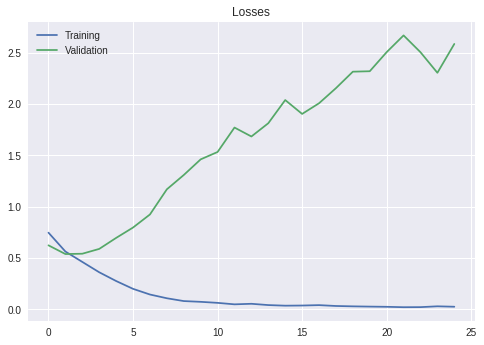

In [95]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Task B

In [170]:
#Select data that does not have subtask_a == "OFF":
train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x7fa37d683840>, {'TIN': 0, 'UNT': 1})


In [171]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 512
dropout = 0.5
n_hidden = (64, 32, 16, 8, 4)

pos_weight = torch.tensor([6.8], device = device) #deals with unbalanced classes

model = ClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = n_hidden)

optimizer = optim.Adam(model.parameters(), lr)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

t_losses, v_losses = train_helper('subtask_b', model, optimizer, loss_fn = loss_fn, epochs = 30, 
                                  train_loader=train_iterator, valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 1.3340

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 1
Iteration 0, loss = 1.3140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 2
Iteration 0, loss = 1.2032

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 3
Iteration 0, loss = 0.9265

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precisi

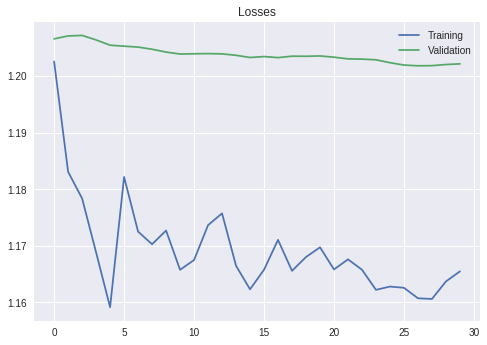

In [172]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

##Task C

In [143]:


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF' and d.subtask_b == 'TIN')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_c)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3101
Validation size: 775
defaultdict(<function _default_unk_index at 0x7fa37d683840>, {'IND': 0, 'GRP': 1, 'OTH': 2})


In [153]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 512
dropout = 0.5
weight = torch.tensor([1.6, 3.7 ,8.4], device = device) #deals with unbalanced classes

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, num_classes=3)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss(weight = weight)


t_losses, v_losses = train_helper('subtask_c', model, optimizer, loss_fn = loss_fn, epochs = 20, train_loader=train_iterator, valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 2.1998

Validation Accuracy:
Got 371 / 775 correct (47.87)
[[209 234  33]
 [ 38 149  20]
 [ 23  56  13]]
              precision    recall  f1-score   support

           0       0.77      0.44      0.56       476
           1       0.34      0.72      0.46       207
           2       0.20      0.14      0.16        92

   micro avg       0.48      0.48      0.48       775
   macro avg       0.44      0.43      0.40       775
weighted avg       0.59      0.48      0.49       775

Kappa 0.1654

Epoch: 1
Iteration 0, loss = 1.3425

Validation Accuracy:
Got 445 / 775 correct (57.42)
[[288 155  33]
 [ 45 141  21]
 [ 31  45  16]]
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       476
           1       0.41      0.68      0.51       207
           2       0.23      0.17      0.20        92

   micro avg       0.57      0.57      0.57       775
   macro avg       0.48      0.49      0.47       775
weighted av

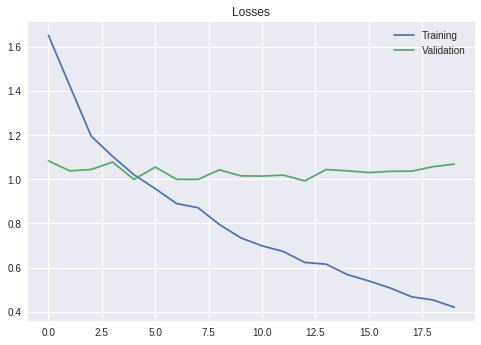

In [154]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()